# Домашнее задание 4

В этом задании мы:
1. Построим классификатор датасета CIFAR с помощью обычных нейросетей и CNN.
2. Поработаем с аугментациями и добьемся большего качества с их помощью.
3. Попрактикуемся с техникой fine-tuning: возьмем готовый MobileNet и дообучим последний слой под нашу задачу.

## Классификация: CNN против обычных сетей

В первой части задания мы повторим то, что проделывалось на лекции.
Но на этот раз будем учить сети до победного, пока их качество не перестанет улучшаться - и сравним результаты.

Также в конце оценим число параметров в каждой сети, чтобы сравнить эффективность CNN и FC при работе с изображениями.

Воспользуемся датасетом CIFAR.

In [1]:
import sys
print(sys.executable)

/root/nlp/.venv/bin/python


In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import perf_counter
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


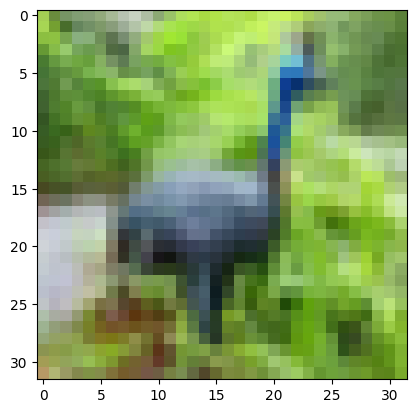

In [2]:
plt.imshow(train_dataset[6][0].permute(1, 2, 0))

In [4]:
train_dataset[9][0]

tensor([[[0.4902, 0.4314, 0.4000,  ..., 0.7922, 0.7843, 0.7922],
         [0.5569, 0.5725, 0.6902,  ..., 0.7647, 0.7765, 0.8000],
         [0.7059, 0.5608, 0.6118,  ..., 0.4784, 0.5451, 0.6196],
         ...,
         [0.4078, 0.3961, 0.3961,  ..., 0.4941, 0.4941, 0.4902],
         [0.4078, 0.4118, 0.4275,  ..., 0.5412, 0.5373, 0.5373],
         [0.4118, 0.4235, 0.4510,  ..., 0.5608, 0.5608, 0.5647]],

        [[0.4902, 0.3961, 0.3529,  ..., 0.8118, 0.8039, 0.8157],
         [0.5725, 0.5647, 0.6745,  ..., 0.7882, 0.8039, 0.8275],
         [0.7255, 0.5725, 0.6157,  ..., 0.4353, 0.5020, 0.5765],
         ...,
         [0.3216, 0.3137, 0.3176,  ..., 0.4039, 0.4039, 0.3961],
         [0.3176, 0.3294, 0.3451,  ..., 0.4431, 0.4431, 0.4392],
         [0.3255, 0.3412, 0.3686,  ..., 0.4588, 0.4549, 0.4549]],

        [[0.4549, 0.3569, 0.3255,  ..., 0.8392, 0.8314, 0.8392],
         [0.5569, 0.5451, 0.6667,  ..., 0.8039, 0.8196, 0.8431],
         [0.7176, 0.5725, 0.6157,  ..., 0.4431, 0.5137, 0.

### Задание №1

Создайте два объекта `DataLoader` и сохраните их в переменные `train_loader` и `test_loader` (для тренировочной и тестовой выборки соответственно).

Используйте размер батча 256.

In [9]:
batch_size = 256

# NOTE Если вы используете num_workers > 1 и хотите полной воспроизводимости, нужно немного добавить кода, см.
# https://pytorch.org/docs/stable/notes/randomness.html#dataloader
# В этом задании опускаем этот момент для простоты - нам важен порядок чисел, случайные флуктуации приемлемы.
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

### Задание №2

Обучите полносвязную сеть для классификации CIFAR.

Достаточно 3 блоков "Linear + ReLU".
Ваша задача - вывести accuracy на _тестовой выборке_ на плато.
Т.е. нужно обучить сеть настолько долго, чтобы увидеть, как ее качество перестает расти с ростом числа эпох.
Для этого попробуйте подвигать `lr` и `num_epochs`.


Сдайте в ЛМС предельный accuracy, который может достичь полносвязная сеть.

In [4]:
for one_batch in train_loader:
    batch_of_images, batch_of_labels = one_batch
    print(type(batch_of_images))
    print(batch_of_images.shape)
    print(type(batch_of_labels))
    print(batch_of_labels.shape)
    break

<class 'torch.Tensor'>
torch.Size([256, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([256])


In [10]:
@dataclass
class TrainConfig:
    lr: float
    num_epochs: int

In [2]:
torch.cuda.is_available() 

True

In [11]:
def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    config: TrainConfig,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    # Перенос модели на GPU, если доступен
    model = model.to(device)
    val_acc = []
    max_accuracy = 0
    # Цикл по эпохам
    for i in range(config.num_epochs):
        model.train()  # Переключение в режим обучения

        for X_batch, y_batch in train_loader:
            # Перенос батча на GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Получение предсказаний модели
            outputs = model(X_batch)

            # Расчёт потерь
            loss = F.cross_entropy(outputs, y_batch)
            loss.backward()  # Обратное распространение ошибки

            # Обновление параметров модели
            optimizer.step()

        # Валидация
        model.eval()  # Переключение в режим валидации
        total_val_acc = 0
        total_val_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Перенос батча на GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Получение предсказаний модели
                val_outputs = model(X_batch)
                # print('### val_outputs')
                # print(val_outputs.shape)
                # print('### val_outputs.argmax(1)')
                # print(val_outputs.argmax(1))
                # print('### y_batch')
                # print(y_batch.shape)

                # Накопление статистики
                total_val_acc += (val_outputs.argmax(1) == y_batch).sum().item()
                total_val_samples += X_batch.size(0)

        # Расчёт средней потери и точности на валидационном наборе
        accuracy = total_val_acc / total_val_samples
        if accuracy > max_accuracy:
            max_accuracy = accuracy
        val_acc.append(accuracy)
        plot_accuracy(i + 1, val_acc, max_accuracy)
    print(f'### max_accuracy = {max_accuracy}')

In [29]:
def plot_accuracy(epoch: int, values: list[float], max_accuracy: float):
    """Пример:

    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    plt.title(f'Epoch {epoch}. Last accuracy: {values[-1]} Max Accuracy: {max_accuracy}')
    plt.ylim(0,1)
    plt.plot(values)
    plt.grid()
    plt.show()
    

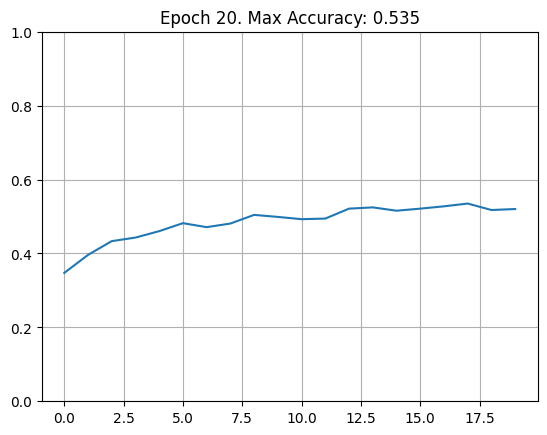

### max_accuracy = 0.535


In [12]:
class SimpleFCNModel(nn.Module):
    
    def __init__(self, num_classes=10):
        
        super().__init__()
              
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 32 * 3, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes),            
        )

    def forward(self, x: torch.Tensor):        
        return self.net(x)
    
    

torch.manual_seed(987)
params = TrainConfig(lr=1e-3, num_epochs=20)
model = SimpleFCNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)


In [13]:
def report_parameters(model: nn.Module):
    print(
        "Суммарное количество параметров:",
        sum(p.nelement() for p in model.parameters()),
    )
    print(
        "Суммарный размер (Мб) параметров:",
        sum(
            parameter.nelement() * parameter.element_size()
            for parameter in model.parameters()
        )
        / 1024**2,
    )

In [14]:
report_parameters(model)

Суммарное количество параметров: 1738890
Суммарный размер (Мб) параметров: 6.633338928222656


### Задание №3

Теперь постройте и обучите CNN сеть.
Опять же, не используйте глубокую сеть: мы хотим иметь схожее количество параметров для сравнения.

Достаточно будет трех блоков "Conv + ReLU + MaxPool".

In [15]:
class SimpleCNNModel(nn.Module):
    
    def explain_output(self, x: torch.Tensor):
        # Печатает размеры тензора на выходе каждого слоя
        print("## Модель ##")
        print(model)
        print("## Размерности")
        print("Пришел x:", x.shape)
        current = x
        for one_layer in self.conv_net:
            print("#######")
            print("Слой:".ljust(8), one_layer)
            print("До:".ljust(8), current.shape)
            current = one_layer(current)
            print("После:".ljust(8), current.shape)
        print("## После всей модели")
        print(self(x).shape)
    
    def __init__(self, num_classes=10):
        
        super().__init__()
              
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x: torch.Tensor):      
        x = self.conv_net(x)
        x = x.view(-1, 128 * 4 * 4)
        return self.fc(x)

In [17]:
def plot_filters(weights, num_filters=32):
    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(6, 6, i + 1)  # 6x6 сетка для 32 фильтров
        filter_weights = weights[i]  # Веса i-го фильтра (размер [3, 3, 3])
        # Визуализируем каждый канал фильтра (RGB)
        filter_weights = filter_weights - filter_weights.min()  # Нормализация
        filter_weights = filter_weights / filter_weights.max()  # Нормализация
        plt.imshow(filter_weights.permute(1, 2, 0))  # Перестановка осей для отображения
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [32]:
# model = SimpleCNNModel()
conv_layer = model.conv_net[0]
weights = conv_layer.weight.data  # Веса фильтров (тензор размером [32, 3, 3, 3])
weights = weights.cpu()

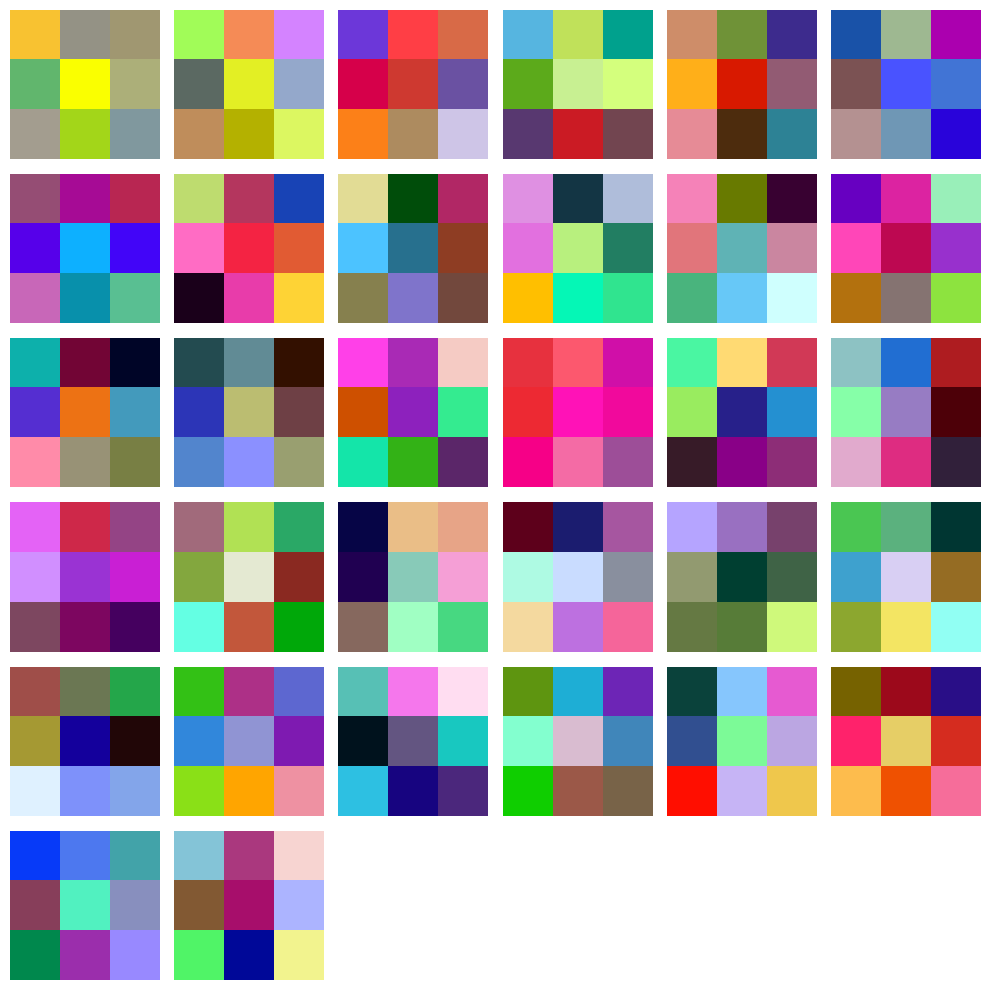

In [33]:
plot_filters(weights)

In [16]:
torch.cuda.empty_cache()

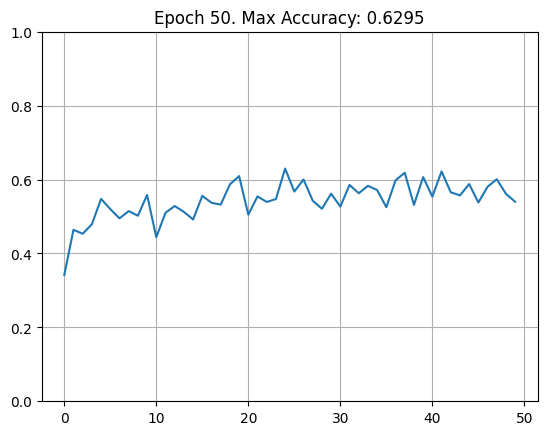

### max_accuracy = 0.6295


In [20]:
torch.manual_seed(987)
params = TrainConfig(lr=1e-2, num_epochs=50)
model = SimpleCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, train_loader, test_loader, optimizer, params)

In [25]:
report_parameters(model)

Суммарное количество параметров: 113738
Суммарный размер (Мб) параметров: 0.43387603759765625


Обратите внимание на качество и на число параметров.
Качество получается выше, а число параметров - на порядок меньше.

Делаем вывод, что CNN позволяют выбивать лучшее качество, чем обычные сети, и при меньшем числе параметров.

Но CNN - не единственный способ улучшить качество при работе с картинками.

### Задание №4
Реализуйте следующие аугментации:
1. Горизонтальное отражение (Horizontal Flip) с вероятностью применения 30%
2. Вращение на угол (Rotate), близкий к 30 градусам, с вероятностью применения около 30%.
3. Random Resized Crop - тут выберите нужные параметры самостоятельно.
4. Normalize. Нормализовать нужно вдоль трех осей изображения. Среднее и std подсчитайте самостоятельно, используя `train_dataset` (в подсчет статистик _нельзя_ включать `test_dataset`).

Используйте библиотеку `albumentations`.
Не забудьте, что `albumentations` работает с numpy-массивами.
Придется перегонять данные из pytorch в numpy-массивы и обратно:

```python
np_array = tensor.numpy()
tensor_back = torch.from_numpy(np_array)
```

Сохраните аугментации в переменную `transforms` и сдайте свой код в ЛМС.

<details>
<summary>Как ваш код будет проверяться</summary>

```python
import albumentations as A

# <Ваш код здесь>

# Затем проверки на переменную transforms
assert some_check(transforms)
assert another_check(transforms)
```
</details>

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 32

transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 0.8), p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.OpticalDistortion(),
        A.GridDistortion(),
        A.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.24703279, 0.24348423, 0.26158753],
            max_pixel_value=1.0,
        ),
        ToTensorV2(),
    ]
)


test_transforms = A.Compose(
    [       
       # A.Normalize(
      #      mean=[0.4914, 0.4822, 0.4465],
      #      std=[0.24703279, 0.24348423, 0.26158753],
      #      max_pixel_value=1.0,
      #  ),
        ToTensorV2(),
    ]
)


## Аугментации
Зачастую аугментации помогают увеличить качество модели.
Объясняется это так: аугментация изображений обогащает датасет новыми картинками, сгенерированными из существующих.
Переобучения не происходит, потому что мы не просто дублируем изображения, а немного изменяем их.
### Задание №5

Обучите CNN с использованием аугментаций.
Как и в прошлых заданиях, держите обучение до конца - пока loss не выйдет на плато.

Ваша задача - получить accuracy выше 76%.
Сдайте в ЛМС:
- код класса модели. Класс должен называться `SimpleCNNModel`;
- .pt файл с обученной моделью;

In [27]:
import cv2 
import torchvision
    
    
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        img_as_np = img.numpy()

        transformed = self.transforms(image=img_as_np.transpose(1, 2, 0))["image"]
        return transformed, label


au_train_dataset = Cifar10SearchDataset(root="./data", train=True, download=True, transform=transforms)
au_test_dataset = Cifar10SearchDataset(root="./data", train=False, download=True, transform=test_transforms)


batch_size = 256

au_train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)


Files already downloaded and verified
Files already downloaded and verified


In [30]:
class SimpleCNNModel(nn.Module):
    
    def __init__(self, num_classes=10):
        
        super().__init__()
              
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),           
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),           
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),           
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x: torch.Tensor):      
        x = self.conv_net(x)
        x = x.view(-1, 128 * 4 * 4)
        return self.fc(x)

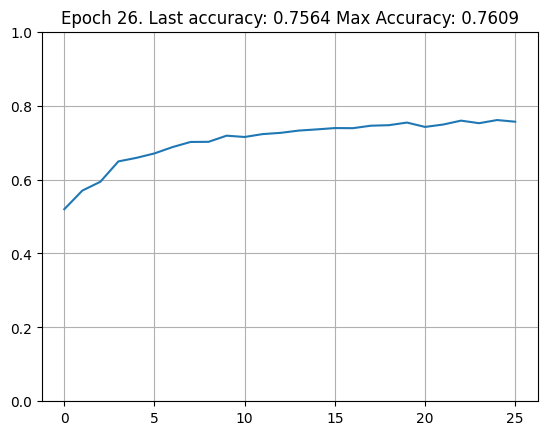

### max_accuracy = 0.7609


In [31]:
torch.manual_seed(987)
params = TrainConfig(lr=1e-3, num_epochs=26)
model = SimpleCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=params.lr)
train_loop(model, au_train_loader, test_loader, optimizer, params)

In [69]:
torch.save(model.state_dict(), 'model.pt')

Аугментации улучшили качество.

Заметьте, что нормализацию можно было бы применить и в прошлом пункте, чтобы более честно оценить, какой прирост дали развороты и вращения изображения.
Советуем самостоятельно провести эксперимент и увидеть различия.

<details>
    <summary>Какие результаты ожидать</summary>
    У авторов получилось около 73% accuracy при использовании только лишь нормализации. При добавлении остальных аугментаций качество было еще выше.
</details>

## Transfer learning
### Задание №6
Transfer learning состоит в том, чтобы взять готовую сеть и дообучить небольшую ее часть.
В этом задании мы будем учить FC слой в конце MobileNet.

Загрузите предварительно обученную модель из серии `MobileNet`, используйте `MobileNet_V3_large`.

Поменяйте ее последний слой (классификатор) на один линейный слой.
Обучите все это дело, меняя **только** параметры своего слоя (подумайте, что передавать в оптимизатор).
Сохраните обученный слой (и только его) в `model_finetune.pt`.

Сдайте в ЛМС .pt файл и код, создающий вашу модель в переменную `model_finetune`.
Чтобы сдать это задание, достаточно набрать accuracy > 40%.

In [ ]:
print(
    "Суммарное количество параметров:",
    sum(p.nelement() for p in trainable_params),
)
print(
    "Суммарный размер (Мб) параметров:",
    sum(
        parameter.nelement() * parameter.element_size()
        for parameter in trainable_params
    )
    / 1024**2,
)

Качество, возможно, просело, зато учим намного меньше параметров.

## Задание №7
Возьмите предпоследний слой вашей CNN модели (тот, что до классификатора).
Этот слой выдает вектора.

Возьмите любой объект из класса 0, подсчитайте его косинусную схождесть со всеми остальными объектами из класса 0, усредните.
Затем подсчитайте то же число, только против всех объектов из класса 1, тоже усредните.
Отправьте в ЛМС два числа, разделенные запятой. Например, "1, 1".

In [ ]:
...

#### Небольшой бонус
Эмбеддинги можно визуализировать, используя t-SNE.
Посмотрите, что получается, попробуйте объяснить картину.

Если модель достаточно качественная, то схожие классы должны собираться в одну кучку, при этом у кучек должны прослеживаться границы.
Конечно же, не забывайте про выбросы.

In [ ]:
from sklearn.manifold import TSNE

result = torch.empty((0, 2048))
labels = []
with torch.no_grad():
    embedding_model.cpu()
    for x_batch, y_batch in test_loader_augs:
        embedding = embedding_model(x_batch).flatten(1)
        embedding /= embedding.norm()
        result = torch.concat((result, embedding))
        labels.extend(y_batch.tolist())

tsne = TSNE(random_state=42)
plot_data = tsne.fit_transform(result.numpy())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
scatter = ax.scatter(
    plot_data[:, 0],
    plot_data[:, 1],
    c=labels,
    cmap="viridis",
    edgecolor="k",
    s=20,
    alpha=1,
)
plt.colorbar(scatter)